# Step 1. Setup and Data Loading


In [2]:
%pip install kmodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

In [3]:
url1 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk.csv"

url2 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk_reference.csv"

In [4]:
# Load raw datasets
gps = pd.read_csv(url1)
ref = pd.read_csv(url2)

print(f"GPS records: {gps.shape[0]:,}, Unique cats: {gps['tag_id'].nunique()}")
print(f"Reference table: {ref.shape[0]} cats, {ref.shape[1]} columns")
print(f"\nGPS columns: {list(gps.columns)}")
print(f"Reference columns: {list(ref.columns)}")

GPS records: 18,215, Unique cats: 101
Reference table: 101 cats, 16 columns

GPS columns: ['tag_id', 'event_id', 'visible', 'timestamp', 'location_long', 'location_lat', 'ground_speed', 'height_above_ellipsoid', 'algorithm_marked_outlier', 'manually_marked_outlier', 'study_name']
Reference columns: ['tag_id', 'animal_id', 'animal_taxon', 'deploy_on_date', 'deploy_off_date', 'hunt', 'prey_p_month', 'animal_reproductive_condition', 'animal_sex', 'hrs_indoors', 'n_cats', 'food_dry', 'food_wet', 'food_other', 'study_site', 'age_years']


In [5]:
# Clean GPS data
gps['timestamp'] = pd.to_datetime(gps['timestamp'], utc=True, errors='coerce')
gps = gps.dropna(subset=['tag_id', 'timestamp', 'location_long', 'location_lat']).copy()
gps = gps.sort_values(['tag_id', 'timestamp']).reset_index(drop=True)

print(f"After cleaning: {gps.shape[0]:,} GPS records for {gps['tag_id'].nunique()} cats")

After cleaning: 18,215 GPS records for 101 cats


# Step 2. Integration Preprocessing

GPS coordinates alone don't tell us real-world distance. And since Earth is a sphere, we need this formula to convert. lat/lon pairs into actual meters between two locations.

- Haversine distance function (from Bruce's M2, adopted as shared utility)

In [107]:
# Haversine formula computes great-circle distance between GPS coordinates.
def haversine_distance(lat1, lon1, lat2, lon2):
    # Vectorized great-circle distance between two sets of points. Returns distance in meters.
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1) # dphi represents the difference in latitude
    dlambda = np.radians(lon2 - lon1) # dlambda for longtitude
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

To calculate how far and how long each cat moved between GPS pings. These step distances and time differences are the building blocks for movement features like speed later on.

In [108]:
# Compute step distances between consecutive GPS points within each cat
# wrap it w groupby('tag_id') so the cats don’t get mixed together
gps['prev_lat'] = gps.groupby('tag_id')['location_lat'].shift(1)
gps['prev_lon'] = gps.groupby('tag_id')['location_long'].shift(1)
gps['prev_time'] = gps.groupby('tag_id')['timestamp'].shift(1)

# remove rows using a mask since the first observation of each cat has no previous point
mask = gps['prev_lat'].notna()
gps.loc[mask, 'step_distance_m'] = haversine_distance(
    gps.loc[mask, 'prev_lat'], gps.loc[mask, 'prev_lon'],
    gps.loc[mask, 'location_lat'], gps.loc[mask, 'location_long']
)
gps.loc[mask, 'time_diff_hrs'] = (
    (gps.loc[mask, 'timestamp'] - gps.loc[mask, 'prev_time']).dt.total_seconds() / 3600
)

print(f"Step distances computed: {gps['step_distance_m'].notna().sum():,} valid steps")

Step distances computed: 18,114 valid steps


** For each GPS ping, this cell calculates how far (step_distance_m)
and how long (time_diff_hrs) each cat has moved since its previous
ping. These two values are the building blocks for speed and
movement features later on.

In [109]:
# Radius of gyration (Adapted from Bruce's M2)
# summarize how widely each cat moved using a single numeric measure
def radius_of_gyration(lats, lons):
    # RMS distance of all points from centroid, in meters.
    if len(lats) == 0:
        return np.nan
    lat_mean = np.mean(lats)
    lon_mean = np.mean(lons)
    dists = haversine_distance(lats, lons, lat_mean, lon_mean)
    return np.sqrt(np.mean(dists ** 2))

In [110]:
# Build unified cat-level feature table
cat_features = gps.groupby('tag_id').apply(lambda g: pd.Series({
    # Tracking metadata
    'n_points': len(g),
    'tracking_hours': (
        (g['timestamp'].max() - g['timestamp'].min()).total_seconds() / 3600
        if len(g) > 1 else 0
    ),

    # Bruce's raw movement features (mean, median, and total step distance, plus radius of gyration)
    'mean_step_m': g['step_distance_m'].mean(),
    'median_step_m': g['step_distance_m'].median(),
    'std_step_m': g['step_distance_m'].std(),
    'total_distance_m': g['step_distance_m'].sum(),
    'radius_of_gyration_m': radius_of_gyration(
        g['location_lat'].values, g['location_long'].values
    ),

    # Erica's (me) features (spatial extent of movement using a bounding box (bbox area, lat/lon spread))
    'bbox_area_deg2': (
        (g['location_long'].max() - g['location_long'].min()) *
        (g['location_lat'].max() - g['location_lat'].min())
    ),
    'lon_std': g['location_long'].std(),
    'lat_std': g['location_lat'].std(),

    # Emily's density-aware features (density-aware metrics like distance per point and distance per hour)
    'dist_per_point_m': (
        g['step_distance_m'].sum() / len(g) if len(g) > 0 else np.nan
    ),
    'bbox_area_per_point': (
        ((g['location_long'].max() - g['location_long'].min()) *
         (g['location_lat'].max() - g['location_lat'].min())) / len(g)
    ),
    'dist_per_hour': (
        g['step_distance_m'].sum() /
        ((g['timestamp'].max() - g['timestamp'].min()).total_seconds() / 3600)
        if len(g) > 1 and
           (g['timestamp'].max() - g['timestamp'].min()).total_seconds() > 0
        else np.nan
    ),
})).reset_index()

# Merge with reference data (household attributes for Allen/Erica)
cat_features = cat_features.merge(ref, on='tag_id', how='left')

print(f"Unified feature table: {cat_features.shape[0]} cats, {cat_features.shape[1]} columns")
cat_features[['tag_id', 'n_points', 'mean_step_m', 'median_step_m',
              'total_distance_m', 'radius_of_gyration_m',
              'dist_per_point_m', 'dist_per_hour']].describe().round(1)

Unified feature table: 101 cats, 29 columns


,n_points,mean_step_m,median_step_m,total_distance_m,radius_of_gyration_m,dist_per_point_m,dist_per_hour
count,101.0,101.0,101.0,101.0,101.0,101.0,101.0
mean,180.3,66.3,28.4,12377.8,225.9,65.7,87.8
std,146.3,82.0,9.2,21253.6,538.8,81.7,157.5
min,12.0,15.6,8.0,417.4,20.5,15.5,7.2
25%,100.0,35.1,22.1,4461.2,54.2,34.8,26.0
50%,155.0,43.6,26.8,6638.3,83.3,43.3,39.9
75%,214.0,62.6,32.9,11415.3,170.3,62.0,80.3
max,963.0,597.1,57.7,147252.0,4239.2,594.5,1047.8


Finally, the table is merged with household reference data to bring in
cat-level attributes for downstream analysis.

# Step 3. Integration: Clustering Stability


Bruce, Emily, and I each independently found that clustering produces no stable behavioral types. Here we test this systematically: K-Means at k=2,3,4 on both raw and density-aware features.

**What changed from M2**: Each member tested clustering on different features with different k. Here we compare all k values on both feature sets under identical conditions.

** The nested loop structure, separate scalers per feature set, and print formatting were developed with LLM assistance (Logic reviewed and understood before use)

In [75]:
# Define feature sets based on the descriptions in the problem
RAW_FEATURES = ['mean_step_m', 'median_step_m', 'std_step_m', 'total_distance_m', 'radius_of_gyration_m', 'bbox_area_deg2', 'lon_std', 'lat_std']
DENSITY_AWARE_FEATURES = ['dist_per_point_m', 'bbox_area_per_point', 'dist_per_hour']

# Drop any cats with missing values in the features we need for clustering
# Using .copy() here to avoid pandas warning about modifying a slice
cat_features_clean = cat_features.dropna(subset=RAW_FEATURES + DENSITY_AWARE_FEATURES).copy()

# Scale raw features
scaler_raw = StandardScaler()
X_raw = scaler_raw.fit_transform(cat_features_clean[RAW_FEATURES])

# Scale density-aware features
scaler_norm = StandardScaler()
X_norm = scaler_norm.fit_transform(cat_features_clean[DENSITY_AWARE_FEATURES])

# Clustering comparison
print(f"{'Feature Set':<20} {'k':>3}    {'Silhouette':>12}     {'Cluster Sizes'}")
print("-" * 97)

# silhouette_score is used to measure how well-separated the clusters are, closer to 1.0 = better defined clusters
for label, X_data in [("RAW", X_raw), ("DENSITY-AWARE", X_norm)]:
    for k in [2, 3, 4]:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_data)
        sil = silhouette_score(X_data, labels)
        sizes = sorted(pd.Series(labels).value_counts().values, reverse=True)
        print(f"{label:<20} {k:>3} {sil:>12.3f}       {sizes}")

Feature Set            k      Silhouette     Cluster Sizes
-------------------------------------------------------------------------------------------------
RAW                    2        0.898       [np.int64(99), np.int64(2)]
RAW                    3        0.455       [np.int64(73), np.int64(26), np.int64(2)]
RAW                    4        0.515       [np.int64(68), np.int64(25), np.int64(6), np.int64(2)]
DENSITY-AWARE          2        0.927       [np.int64(99), np.int64(2)]
DENSITY-AWARE          3        0.763       [np.int64(94), np.int64(5), np.int64(2)]
DENSITY-AWARE          4        0.664       [np.int64(79), np.int64(18), np.int64(2), np.int64(2)]


Both feature sets show the highest silhouette score at k=2, but the cluster sizes are extremely unbalanced (99 vs 2), suggesting no meaningful behavioral groupings exist.

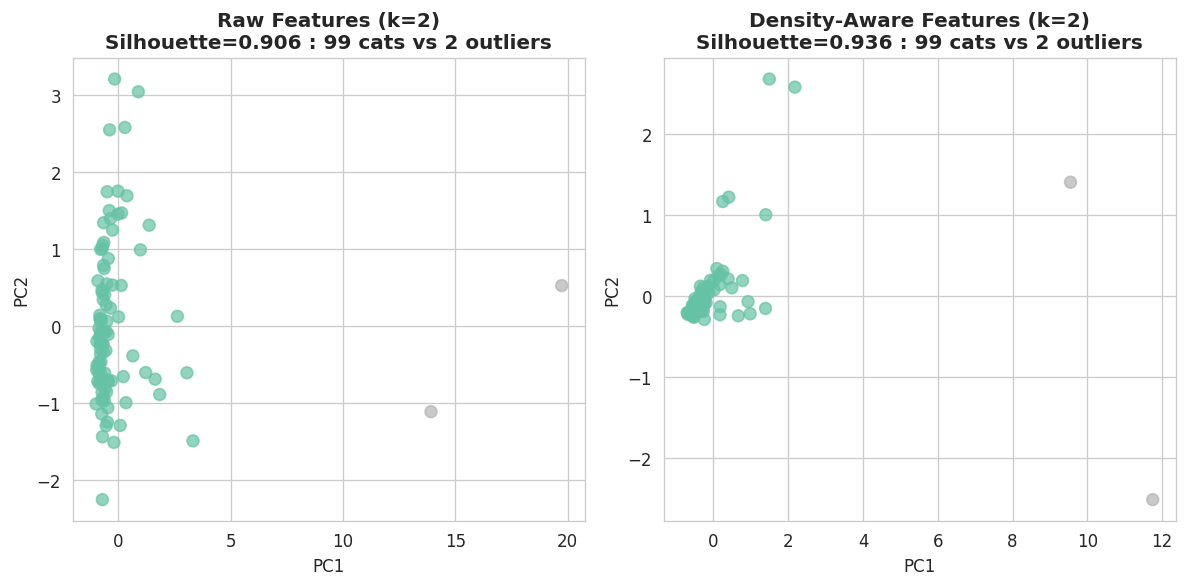

In [111]:
# Clustering visualization
# chose k=2 based on the silhouette scores from the previous cell.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Reduce to 2D using PCA for visualization.
# PCA rotates and compresses the data into 2 dimensions without losing the underlying structure and all the original variation is still captured, just represented in fewer dimensions.
# (can't visualize 8 features at once, so PCA compresses them into 2 axes)
pca = PCA(n_components=2)
scores_raw = pca.fit_transform(X_raw)
scores_norm = pca.fit_transform(X_norm)

# Run k=2 clustering on both feature sets and plot side by side
km_raw = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(scores_raw)
sil_raw = silhouette_score(scores_raw, km_raw)
axes[0].scatter(scores_raw[:, 0], scores_raw[:, 1], c=km_raw, cmap='Set2', alpha=0.7, s=50)
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
sizes_raw = sorted(pd.Series(km_raw).value_counts().values, reverse=True)
axes[0].set_title(f'Raw Features (k=2)\nSilhouette={sil_raw:.3f} : {sizes_raw[0]} cats vs {sizes_raw[1]} outliers',
                  fontsize=12, fontweight='bold')

km_norm = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(scores_norm)
sil_norm = silhouette_score(scores_norm, km_norm)
axes[1].scatter(scores_norm[:, 0], scores_norm[:, 1], c=km_norm, cmap='Set2', alpha=0.7, s=50)
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
sizes_norm = sorted(pd.Series(km_norm).value_counts().values, reverse=True)
axes[1].set_title(f'Density-Aware Features (k=2)\nSilhouette={sil_norm:.3f} : {sizes_norm[0]} cats vs {sizes_norm[1]} outliers',
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

PCA was applied purely for visualization purposes and it compresses the feature space into 2D without losing the information in the data, so the cluster structure we see here still reflects the original features.

Both plots show one very large cluster and one tiny cluster (99 vs 2 cats),
which means k-means is not finding meaningful behavioral groups and it's just
separating outliers from the rest. The high silhouette scores are misleading
here because of this extreme imbalance. This confirms that clustering alone
is not sufficient to identify distinct movement types in this dataset.

#### **Key finding: Both feature sets produce identical structure**
99 cats in main cluster, 2 extreme outliers. Behavioral variation is continuous, not categorical, which is why clustering fails to find meaningful groups here.

# Step 4. Integration: Preprocessing Sensitivity

Bruce filtered to ≥ 80 GPS points, I filtered cats with ≥ 50, Emily kept all cats. Rather than choosing one threshold, we test sensitivity of PCA structure and clustering stability across thresholds.

**What changed from M2: No member tested sensitivity to their filtering choice.**

In [112]:
# Sensitivity analysis across filtering thresholds
thresholds = [0, 10, 20, 30, 50, 80]
results = []
#From Integration 1 (reusing the same density features)
density_features = ['dist_per_point_m', 'dist_per_hour',
                    'radius_of_gyration_m', 'median_step_m']

for t in thresholds:
    # Filter to only cats with at least t GPS points
    subset = cat_features[cat_features['n_points'] >= t]
    sub_clean = subset[density_features].dropna()

    # Skip if too few cats remain to cluster meaningfully
    if len(sub_clean) < 5:
        continue

    # Scale, compress to 2D (without losing information), and cluster
    X_sub = StandardScaler().fit_transform(sub_clean)
    pca_sub = PCA(n_components=2)
    scores_sub = pca_sub.fit_transform(X_sub)

    # Try to find how much variance does PC1 explain
    pc1_var = pca_sub.explained_variance_ratio_[0]

    # Try to check PC1 correlated with how many GPS points a cat has (density bias check)
    # Using Spearman because the relationship might not be linear (chosen with LLM assistance, reviewed and understood before use)
    pc1_dens = pd.DataFrame({
        'PC1': scores_sub[:, 0],
        'n': subset.loc[sub_clean.index, 'n_points'].values
    }).corr(method='spearman').iloc[0, 1]

    km = KMeans(n_clusters=2, random_state=42, n_init=10)
    labs = km.fit_predict(X_sub)
    sil = silhouette_score(X_sub, labs)

    results.append({
        'threshold': t, 'n_cats': len(sub_clean),
        'PC1_var': pc1_var, 'PC1_density_corr': pc1_dens,
        'silhouette': sil
    })

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

 threshold  n_cats  PC1_var  PC1_density_corr  silhouette
         0     101 0.681325          0.498695    0.858255
        10     101 0.681325          0.498695    0.858255
        20     100 0.681140          0.480983    0.857628
        30     100 0.681140          0.480983    0.857628
        50      98 0.681565          0.499653    0.856357
        80      84 0.684803          0.471046    0.847096


Across all thresholds, PC1 variance (0.68) and silhouette scores (0.85)
remain nearly identical. This suggests our results are robust and the choice of filtering threshold does not meaningfully change the structure
of the data or the clustering outcome.

# Visuals (Sensitivity plot)

The three lines are plotted together to compare how different filtering thresholds affect the same underlying outcome. This allows us to directly assess whether the choice of threshold meaningfully changes the observed pattern.

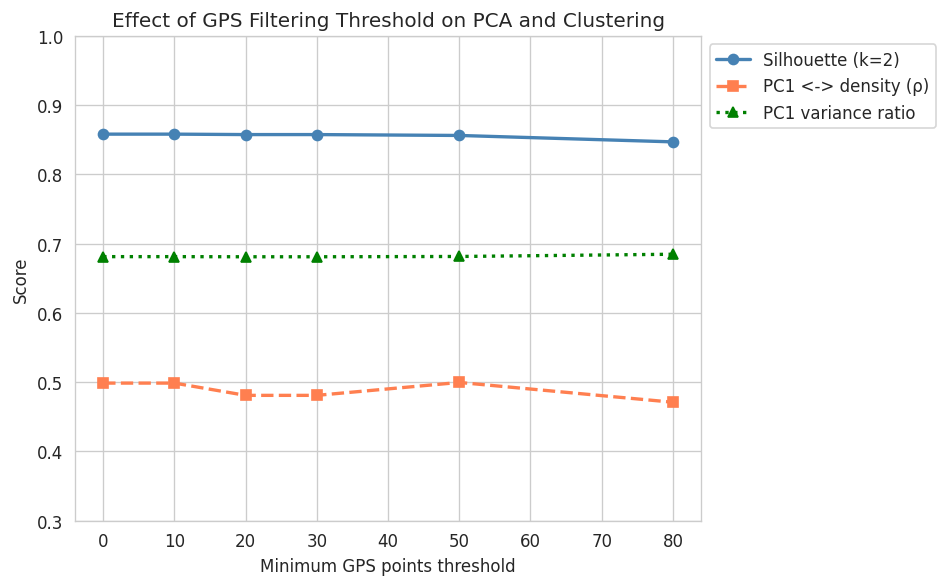

In [113]:
# Sensitivity plot

fig, ax = plt.subplots(figsize=(8, 5))

# Blue: silhouette score : stays high means clustering is consistent
ax.plot(res_df['threshold'], res_df['silhouette'], 'o-',
        label='Silhouette (k=2)', color='steelblue', linewidth=2)

# Orange: correlation between PC1 and number of GPS points : wanted to check if PCA is just reacting to data quantity, not real movement
ax.plot(res_df['threshold'], res_df['PC1_density_corr'], 's--',
        label='PC1 <-> density (ρ)', color='coral', linewidth=2)

# Green: how much variance PC1 explains : stable around 0.68 across all thresholds
ax.plot(res_df['threshold'], res_df['PC1_var'], '^:',
        label='PC1 variance ratio', color='green', linewidth=2)

ax.set_xlabel('Minimum GPS points threshold')
ax.set_ylabel('Score')
ax.set_title('Effect of GPS Filtering Threshold on PCA and Clustering')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(0.3, 1.0)

plt.tight_layout()
# dpi = dots per inch : controls image resolution (150 = clear enough for a report)
plt.savefig('fig_preprocessing_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

Key finding: All three metrics remain stable across thresholds, confirming that density-aware features already account for observation count, making the filtering threshold an inconsequential decision.

All three lines stay nearly flat across thresholds : silhouette (0.85), PC1 variance (0.68), and density correlation (0.50) barely change even as we go from 101 cats down to 84.This means our preprocessing choice was not a critical decision and the structure in the data is stable regardless of which threshold each team member used.

# Step 5. Integration 6: Indoor Access Stratification

My M2 restricted analysis to mostly-indoor cats to control for environmental constraints. Here we apply her indoor-access framework to Emily's density-aware features and test all three access groups.

**What changed from M2**: I used raw features on indoor cats only. Here we use density-aware features across all access groups.

In [115]:
# Indoor access categorization (from my M2)
cat_features['indoor_access'] = cat_features['hrs_indoors'].apply(
    lambda x: 'Mostly indoor' if x >= 12
    else ('Mostly outdoor' if x < 6 else 'Mixed')
    if pd.notna(x) else np.nan
)

print("Indoor access group sizes:")
print(cat_features['indoor_access'].value_counts())

Indoor access group sizes:
indoor_access
Mostly indoor     62
Mixed             31
Mostly outdoor     8
Name: count, dtype: int64


In [116]:
# Analyze each group : comparing movement patterns by indoor access type
# Wanted to see if cats with different levels of outdoor access actually move differently
for group in ['Mostly indoor', 'Mixed', 'Mostly outdoor']:
    subset = cat_features[cat_features['indoor_access'] == group]
    sub_clean = subset[density_features].dropna()

    # again,skip groups with too few cats to cluster meaningfully
    if len(sub_clean) < 5:
        print(f"\n{group} (n={len(sub_clean)}): too few cats for analysis")
        continue

    X_sub = StandardScaler().fit_transform(sub_clean)

    # K-Means k=2 (using min(2, len) as a safety check in case a group has only 1 cat)
    k = min(2, len(sub_clean))  # make sure we don't ask for more clusters than we have cats
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(X_sub)

    if len(set(labs)) > 1:  # silhouette only works if 2 clusters actually formed
       sil = silhouette_score(X_sub, labs)
    else:
       sil = float('nan')

    # Print mean, std, and skew per feature : skew tells us if the distribution is pulled by extreme outliers
    # skew > 1 means the distribution is pulled by a few extreme outliers so the mean alone doesn't tell the full story
    print(f"\n{group} (n={len(sub_clean)}):  k=2 silhouette = {sil:.3f}")
    for col in density_features:
        vals = subset[col].dropna()
        print(f"  {col}: mean={vals.mean():.1f}, std={vals.std():.1f}, skew={vals.skew():.2f}")


Mostly indoor (n=62):  k=2 silhouette = 0.604
  dist_per_point_m: mean=58.0, std=39.1, skew=2.15
  dist_per_hour: mean=76.1, std=109.9, skew=4.00
  radius_of_gyration_m: mean=176.8, std=225.0, skew=2.35
  median_step_m: mean=28.3, std=9.8, skew=1.23

Mixed (n=31):  k=2 silhouette = 0.825
  dist_per_point_m: mean=69.6, std=97.3, skew=4.71
  dist_per_hour: mean=79.5, std=158.8, skew=4.63
  radius_of_gyration_m: mean=255.1, std=748.3, skew=5.37
  median_step_m: mean=29.1, std=7.2, skew=0.65

Mostly outdoor (n=8):  k=2 silhouette = 0.644
  dist_per_point_m: mean=110.3, std=196.2, skew=2.80
  dist_per_hour: mean=210.5, std=349.3, skew=2.51
  radius_of_gyration_m: mean=492.9, std=1095.6, skew=2.81
  median_step_m: mean=26.7, std=12.3, skew=-0.08


Mostly outdoor cats move roughly twice as far per hour (210.5m)
and have a much larger radius of gyration (492.9m) compared to
mostly indoor cats (76.1m/hr, 176.8m). However, all three groups
show high skew and a few extreme individuals are pulling the means up, so the "average" cat in each group may not be representative.

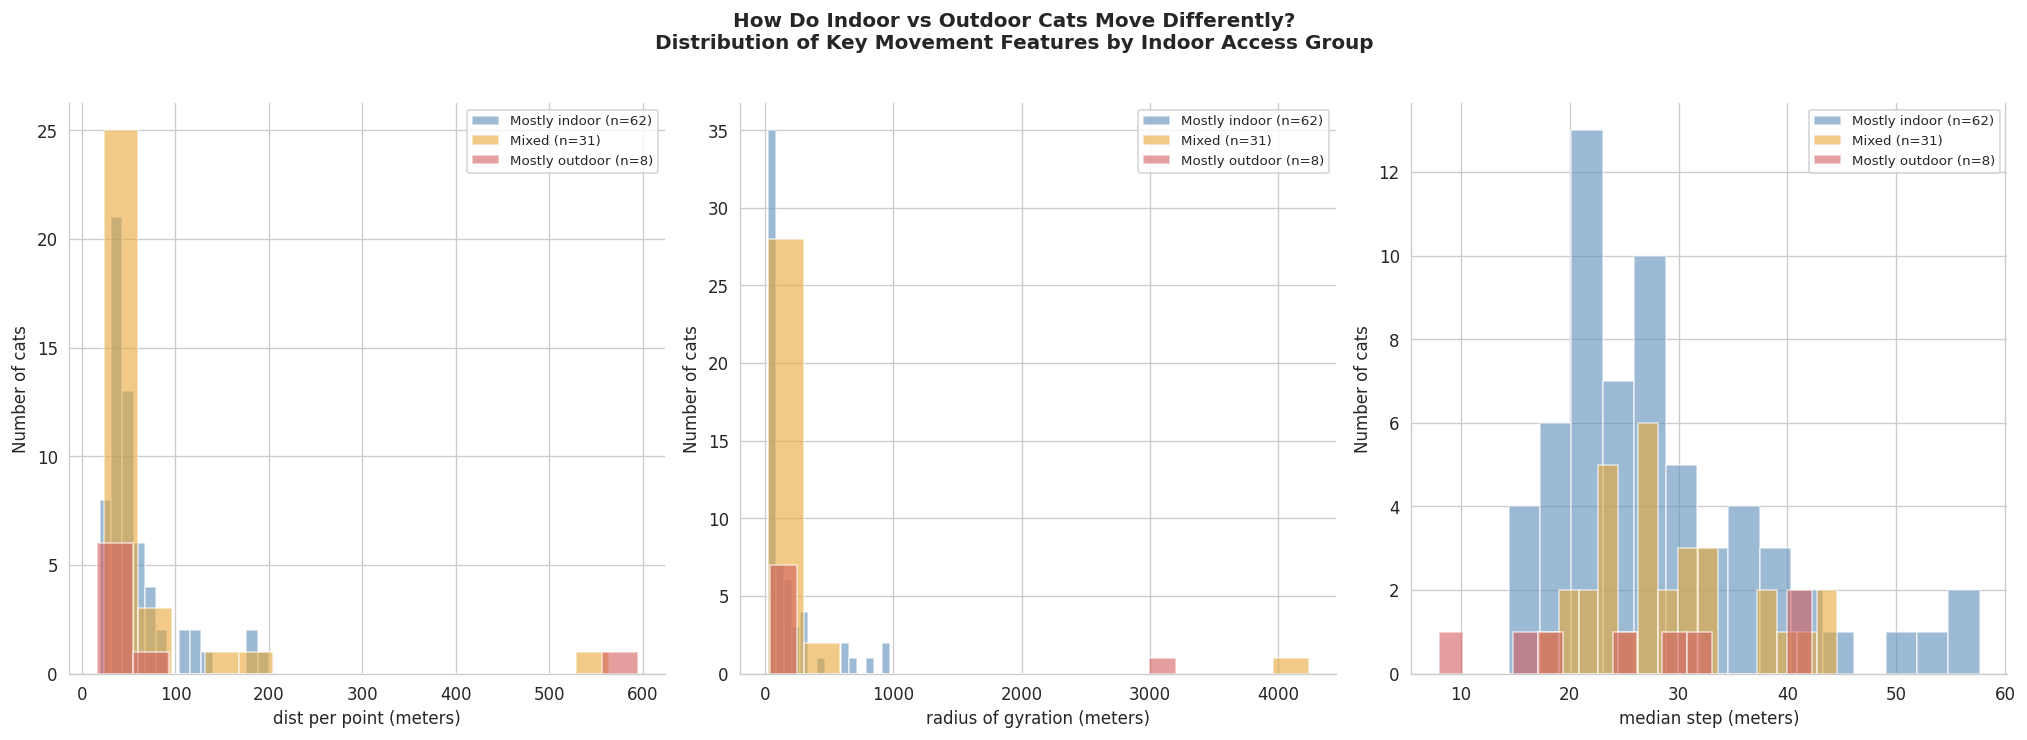

In [100]:
# Distribution plots by indoor access group

# Chose these 3 features because they best capture how much and how far cats move
fig, axes = plt.subplots(1, 3, figsize=(17, 6))
plot_features = ['dist_per_point_m', 'radius_of_gyration_m', 'median_step_m']

# Custom colors
group_colors = {
    'Mostly indoor': '#5B8DB8',
    'Mixed': '#E8A838',
    'Mostly outdoor': '#D45F5F'
}

for i, feat in enumerate(plot_features):
    for group in ['Mostly indoor', 'Mixed', 'Mostly outdoor']:
        data = cat_features[cat_features['indoor_access'] == group][feat].dropna()
        if len(data) > 2:
            axes[i].hist(data, alpha=0.6,
                        label=f"{group} (n={len(data)})",
                        bins=15,
                        color=group_colors[group],
                        edgecolor='white')

    # axis labels
    axes[i].set_xlabel(feat.replace('_', ' ').replace(' m', ' (meters)'), fontsize=10)
    axes[i].set_ylabel('Number of cats', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.suptitle('How Do Indoor vs Outdoor Cats Move Differently?\nDistribution of Key Movement Features by Indoor Access Group',
             y=1.02, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_indoor_stratification.png', dpi=150, bbox_inches='tight')
plt.show()

All three groups show right-skewed, continuous distributions with
no clear separation between groups, confirming that my M2 finding
that indoor access creates a behavioral continuum, not distinct categories.

Mostly outdoor cats tend to have higher dist_per_point and radius_of_gyration, but the overlap between groups is large, meaning indoor access alone doesn't cleanly predict how much a cat moves.

# Step 5. Integration: Feature Redundancy Analysis

**What changed from M2**

Multiple members noted high feature redundancy in M2. Here we examine redundancy across ALL movement features from all members in a single analysis.


** The overall visualization structure and color scheme were developed with LLM assistance for coding support, while the PCA implementation, feature interpretation, and analytical decisions were independently conducted, reviewed, and understood before use.


In [123]:
all_movement = [
    'bbox_area_deg2', 'bbox_area_per_point', 'lon_std',
    'radius_of_gyration_m', 'lat_std', 'total_distance_m',
    'mean_step_m', 'dist_per_hour', 'median_step_m',
    'dist_per_point_m', 'std_step_m'
]

corr_all = cat_features[all_movement].dropna().corr(method='spearman')

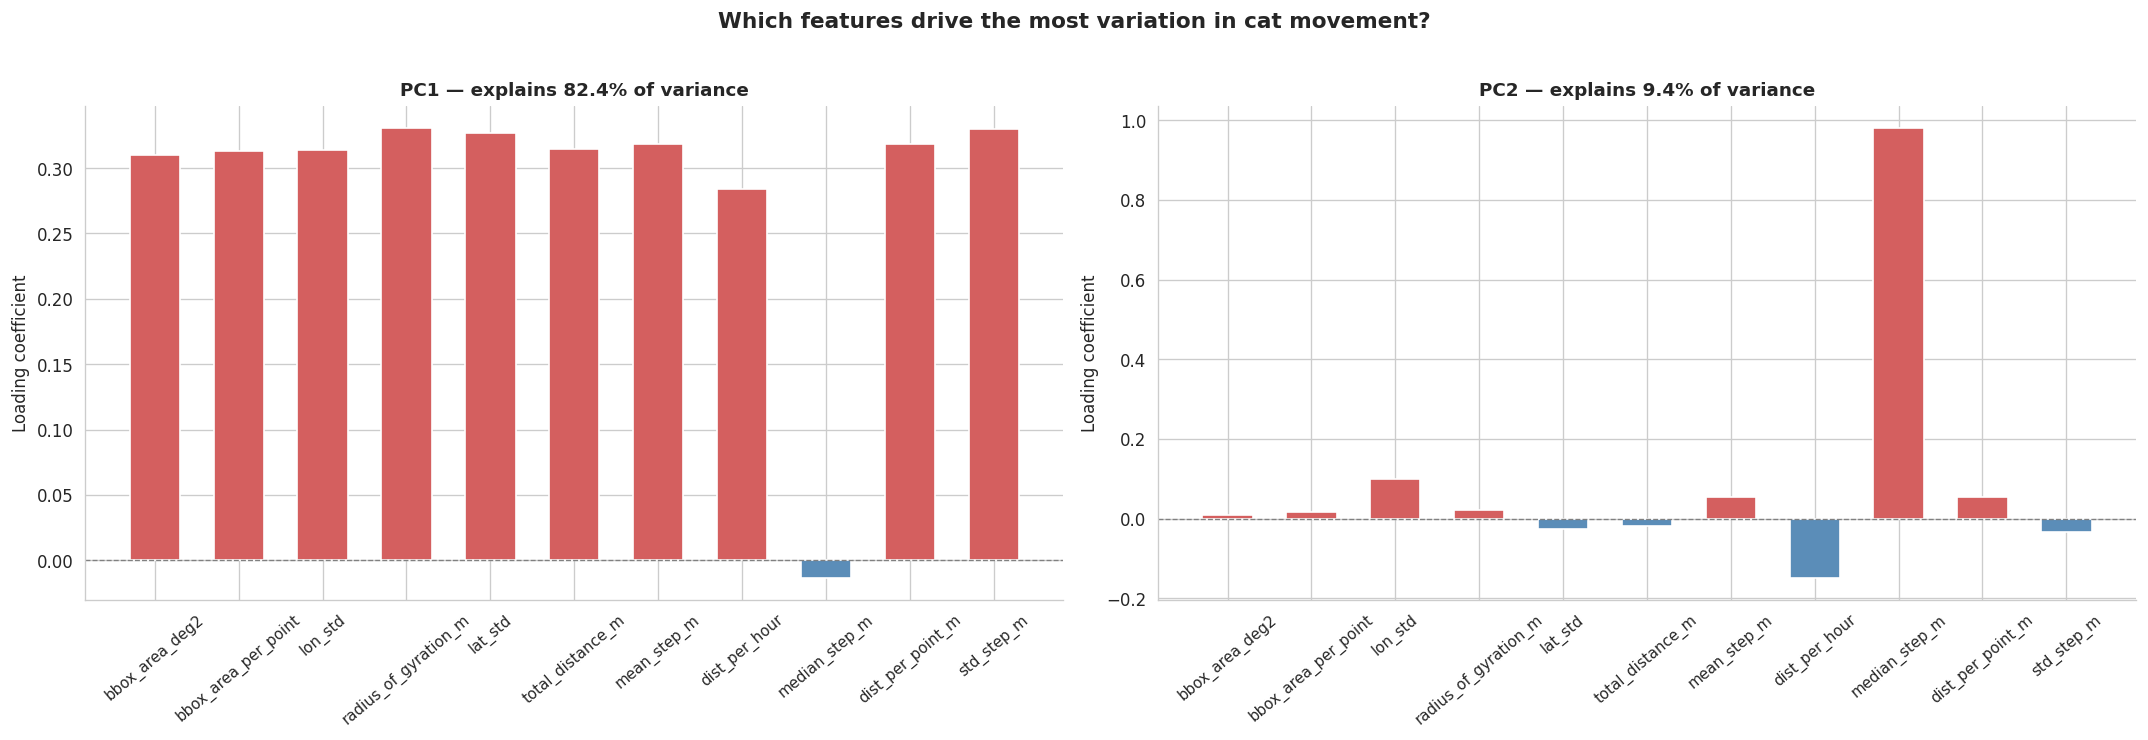

In [124]:
# PCA loadings bar chart : shows which features contribute most to PC1 and PC2

# Step 1: fit PCA on all movement features
X_scaled = StandardScaler().fit_transform(cat_features[all_movement].dropna())
pca_full = PCA(n_components=2)
pca_full.fit(X_scaled)

# Step 2: pull out the loadings — how much each feature contributes to each PC
loadings = pd.DataFrame(
    pca_full.components_.T,
    index=all_movement,
    columns=['PC1', 'PC2']
)

# Step 3: plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, pc in enumerate(['PC1', 'PC2']):

    # red if positive contribution, blue if negative
    colors = ['#D45F5F' if v > 0 else '#5B8DB8' for v in loadings[pc]]

    axes[i].bar(loadings.index, loadings[pc], color=colors, edgecolor='white', width=0.6)
    axes[i].axhline(0, color='gray', linewidth=0.8, linestyle='--')
    axes[i].set_title(f'{pc} — explains {pca_full.explained_variance_ratio_[i]:.1%} of variance',
                      fontsize=11, fontweight='bold')
    axes[i].set_ylim(auto=True)  # let matplotlib decide the best y range
    axes[i].set_ylabel('Loading coefficient', fontsize=10)
    axes[i].tick_params(axis='x', rotation=40, labelsize=9)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.suptitle('Which features drive the most variation in cat movement?',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_pca_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

PC1 explains 82.4% of variance and all features load positively and similarly, confirming that most features are measuring the same thing (overall movement intensity).

PC1 and PC2 together explain 91.8% of variance, meaning we can compress 11 features down to 2 dimensions without losing much information. This confirms high redundancy across all team members' features.

PC2 explains only 9.4%, with median_step_m standing out as the only feature that behaves differently from the rest.

** LLM assistance was used to help structure the pairwise iteration logic (upper-triangular loop using i+1), implement the |rho| threshold filtering, and format the printed output; the choice of Spearman correlation, threshold (0.80), and redundancy interpretation were independently determined and reviewed before use.

In [125]:
# Identify high-redundancy pairs
# Threshold of 0.80 chosen to flag features that are strongly correlated

# Calculate the correlation matrix for all movement features
corr_all = cat_features[all_movement].dropna().corr(method='spearman')

print("Feature pairs with |Spearman rho| > 0.80:")
print("=" * 60)

count = 0

# Go through every unique pair of features
# j starts at i+1 so we don't count the same pair twice
for i in range(len(all_movement)):
    for j in range(i + 1, len(all_movement)):
        # Ensure indices are within bounds of corr_all if cat_features.dropna() reduced columns
        if all_movement[i] in corr_all.columns and all_movement[j] in corr_all.columns:
            r = corr_all.loc[all_movement[i], all_movement[j]]

            # flag it if the two features are highly correlated in either direction
            if abs(r) > 0.80:
                print(f"  {all_movement[i]:25s} <-> {all_movement[j]:25s}  rho={r:+.3f}")
                count += 1

# n*(n-1)/2 gives the total number of unique pairs possible
total_pairs = len(all_movement) * (len(all_movement) - 1) // 2
print(f"\n{count} of {total_pairs} pairs are highly redundant (|rho| > 0.80)")

Feature pairs with |Spearman rho| > 0.80:
  bbox_area_deg2            <-> bbox_area_per_point        rho=+0.916
  bbox_area_deg2            <-> lon_std                    rho=+0.862
  bbox_area_deg2            <-> radius_of_gyration_m       rho=+0.931
  bbox_area_deg2            <-> lat_std                    rho=+0.881
  bbox_area_deg2            <-> total_distance_m           rho=+0.820
  bbox_area_deg2            <-> mean_step_m                rho=+0.820
  bbox_area_deg2            <-> dist_per_point_m           rho=+0.827
  bbox_area_deg2            <-> std_step_m                 rho=+0.911
  bbox_area_per_point       <-> lon_std                    rho=+0.844
  bbox_area_per_point       <-> radius_of_gyration_m       rho=+0.917
  bbox_area_per_point       <-> lat_std                    rho=+0.869
  bbox_area_per_point       <-> mean_step_m                rho=+0.877
  bbox_area_per_point       <-> dist_per_point_m           rho=+0.879
  bbox_area_per_point       <-> std_step_m      

28 out of 55 possible pairs are highly redundant (rho > 0.80) : more than half of all feature combinations are measuring the same thing.

median_step_m is the only feature that is consistently non-redundant !! Suggesting it captures something genuinely different from the rest.

Furthermore,this confirms that despite 11 features across all team members, the effective dimensionality is only ~2: overall spatial scale and per-step behavior, without losing much information.